# Application du GMM au fichier score

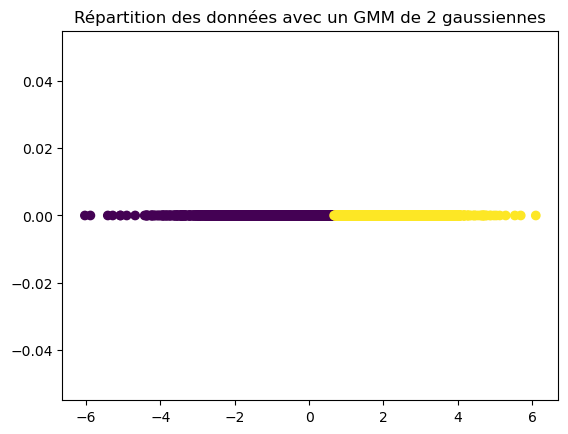

Matrice de covariance : 
 [[[2.07202715]]

 [[1.55359738]]] 

Matrice des moyennes : 
 [[-0.75035948]
 [ 1.78905383]]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import norm
from sklearn.metrics import accuracy_score

# Chargement des donnees
data = np.loadtxt("Score.txt")

# Séparer les données positives des négatives
pos = np.where(data[:,0] == 1.)
neg = np.where(data[:,0] == -1.)

datapos = data[pos,1] # ensemble des donnees positives
dataneg = data[neg,1] # ensemble des donnees nefatives

# Prendre 2/3 & 1/3 de chacune des donnees positives et négatives respectivement pour le training et pour le test
n, m = int((2*datapos.shape[1])/3), int((2*dataneg.shape[1])/3)
train1, train2, test1, test2 = datapos[:, :n+1], dataneg[:, :m+1], datapos[:, n+1:], dataneg[:, m+1:]

newdatatrain = np.concatenate((train1, train2), axis = 1) # ensemble des donnees de training
newdatatest = np.concatenate((test1, test2), axis = 1) # ensemble des donnees de training

np.random.shuffle(newdatatrain) # mélanger les données de training entre elles

# Attribution des vraies etiquettes aux données de test {1 pour les données positives & 0 pour les données négatives}
label = [1 for _ in range(n+1, datapos.shape[1])]
label.extend([0 for _ in range(m+1, dataneg.shape[1])])
label = np.array(label)

newdata = np.concatenate((datapos, dataneg), axis = 1) # ensemble des donnees globales

# Creer et entrainer un GMM avec 2 gaussiennes sur l'ensemble de training {une initialisation avec kmeans}
GM = GaussianMixture(n_components = 2, random_state = 0, init_params = 'kmeans').fit(newdatatrain.T)

# Prédire les clusters pour chaque point de données de test
labels = GM.predict(newdatatest.T)

# Afficher les résultats de la prédiction sur les donnees de test
plt.scatter(newdatatest, np.zeros_like(newdatatest), c = labels, cmap = 'viridis')
plt.title('Répartition des données avec un GMM de 2 gaussiennes')
plt.show()

# Recuperer les valeurs de covariances et moyennes pour chaque gaussienne
covariances = GM.covariances_
means = GM.means_

# Afficher les valeurs
print(f'Matrice de covariance : \n {covariances} \n')
print(f'Matrice des moyennes : \n {means}')

# Performance du GMM sur l'ensemble de test

In [14]:
# Prédire les probabilités d'appartenance à chaque composante gaussienne pour chaque point de données
proba = GM.predict_proba(newdatatest.T)

# Sélectionner la composante gaussienne avec la probabilité la plus élevée pour chaque point de donnée
predicted_labels = proba.argmax(axis = 1)

# Calcul de la precision
accuracy = accuracy_score(label.T, predicted_labels)

# Calcul du taux d'erreur
error_rate = 1 - accuracy

print(f"Accuracy : {np.round(accuracy*100, 2)} %")
print(f"Error rate : {np.round(error_rate*100, 2)} %")

Accuracy : 87.14 %
Error rate : 12.86 %


# Performance du GMM sur chaque classe de l'ensemble de test

In [15]:
# Initialiser un dictionnaire pour stocker les taux d'erreur pour chaque classe {1 pour les positifs & 0 pour les négatifs}
class_error_rates = {}

# Calculer le taux d'erreur pour chaque classe
for true_class in np.unique(label.T):
    # Sélectionner les points de données appartenant à la classe vraie
    true_class_indices = (label.T == true_class)
    # Sélectionner les prédictions correspondantes
    predicted_class_labels = predicted_labels[true_class_indices]
    # Compter le nombre de prédictions incorrectes pour cette classe
    incorrect_predictions = np.sum(predicted_class_labels != true_class)
    # Calculer le taux d'erreur pour cette classe
    error_rate = incorrect_predictions / np.sum(true_class_indices)
    # Stocker le taux d'erreur dans le dictionnaire
    class_error_rates[true_class] = error_rate

# Afficher les taux d'erreur pour chaque classe
for true_class, error_rate in class_error_rates.items() : print(f"Error rate for class {true_class}: {np.round(error_rate*100, 2)}%")

Error rate for class 0: 19.1%
Error rate for class 1: 1.67%


# Tracer les deux gaussiennes

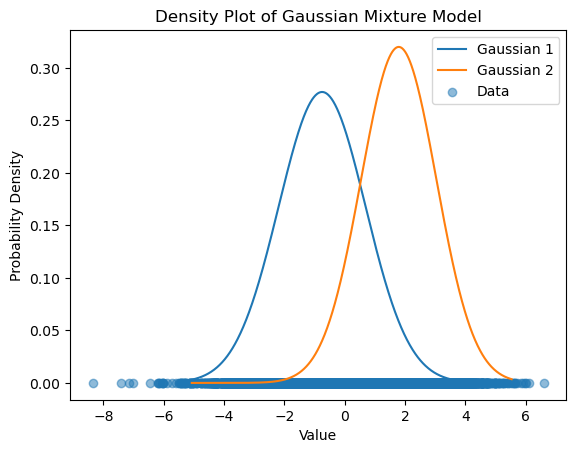

In [16]:
# Obtenir les moyennes et les écarts-types des composantes gaussiennes
means = GM.means_.flatten()
covariances = np.sqrt(GM.covariances_.flatten())

# Créer un espace linéaire pour tracer les courbes de densité de probabilité
x = np.linspace(np.min(means - 3 * covariances), np.max(means + 3 * covariances), 1000)

# Calculer les densités de probabilité pour chaque composante gaussienne
pdf1 = norm.pdf(x, means[0], covariances[0])
pdf2 = norm.pdf(x, means[1], covariances[1])

# Tracer les courbes de densité de probabilité
plt.plot(x, pdf1, label = 'Gaussian 1')
plt.plot(x, pdf2, label = 'Gaussian 2')

# Tracer les points de données
plt.scatter(newdata.T, np.zeros_like(newdata.T), alpha = 0.5, label = 'Data')

plt.title('Density Plot of Gaussian Mixture Model')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()